In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import time
import os

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def custom_weight_init(layer):
    if isinstance(layer, nn.Linear):
        nn.init.xavier_normal_(layer.weight)


class NeuralNet(nn.Module):
    def __init__(self, layers):
        super(NeuralNet, self).__init__()
        self.layers = layers
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 2)]
        )
        self.output_layer = nn.Linear(layers[-2], layers[-1])

    def forward(self, r):
        x = r
        for hidden_layer in self.hidden_layers:
            x = F.tanh(hidden_layer(x))
        y = self.output_layer(x)
        return y


class PINN(nn.Module):
    def __init__(self, layers, L1, D1, L2, D2, S, a, r_f1, r_b1, phi_b1, r_f2, r_b2, phi_b2):
        super(PINN, self).__init__()
        self.dnn = NeuralNet(layers).to(device)
        self.L1 = L1
        self.L2 = L2
        self.D1 = D1
        self.D2 = D2
        self.S = S
        self.a = a
        self.r_f1 = r_f1
        self.r_b1 = r_b1
        self.phi_b1 = phi_b1
        self.r_f2 = r_f2
        self.r_b2 = r_b2
        self.phi_b2 = phi_b2
        self.losses = []
        self.losses_r1 = []
        self.losses_r2 = []
        self.losses_bc1 = []
        self.losses_bc2 = []

    def forward(self, r):
        y = self.dnn(r)
        return y

    def f(self, r, L):
        phi = self.forward(r)
        phi_r = torch.autograd.grad(phi.sum(), r, create_graph=True)[0]
        phi_rr = torch.autograd.grad(phi_r.sum(), r, create_graph=True)[0]
        return phi_rr - phi / L**2

    def bc(self, r):
        phi = self.forward(r)
        phi_r = torch.autograd.grad(phi.sum(), r, create_graph=True)[0]
        return -self.D * phi_r - self.S / 2.0

    def loss_func(self):
        f_pred1 = self.f(self.r_f1, self.L1)
        f_pred2 = self.f(self.r_f2, self.L2)
        # bc_pred = self.bc(self.r_b)
        bc_pred1 = self.forward(self.r_b1)
        bc_pred2 = self.forward(self.r_b2)
        self.loss_r1 = torch.mean(torch.square(f_pred1))
        self.loss_bc1 = torch.mean(torch.square(bc_pred1 - self.phi_b1))
        self.loss_r2 = torch.mean(torch.square(f_pred2))
        self.loss_bc2 = torch.mean(torch.square(bc_pred2 - self.phi_b2))
        self.loss = self.loss_r1 + self.loss_bc1 + self.loss_r2 + self.loss_bc2
        return self.loss

    def predict(self, r):
        phi = self.forward(r)
        # phi_r = torch.autograd.grad(phi.sum(), r, create_graph=True)[0]
        return phi.detach().cpu().numpy()  # , phi_r.detach().cpu().numpy()

In [4]:
def ExactPhi1(x, L1, D1, L2, D2, S, a):
    A1 = -S * L1 / (2 * D1)
    C1 = S * L1 / (2 * D1) * (D1 * L2 * np.cosh(a/(2*L1)) + D2*L1*np.sinh(a/(2*L1))) / (D2*L1*np.cosh(a/(2*L1)) + D1*L2*np.sinh(a/(2*L1)))
    phi = A1 * np.sinh(np.abs(x) / L1) + C1 * np.cosh(np.abs(x) / L1)
    return phi

def ExactPhi2(x, L1, D1, L2, D2, S, a):
    A2 = S*L1*L2/2*np.exp(a/(2*L2))/(D2*L1*np.cosh(a/(2*L1))+D1*L2*np.sinh(a/(2*L1)))
    phi = A2 * np.exp(-np.abs(x) / L2)
    return phi

# Medium 1
Nf1 = 1000
Nb1 = 100
L1 = np.sqrt(0.03)
lambda_tr1 = 0.0228
D1 = 1 / 3 * lambda_tr1
S = 1
a = 2.0
# Medium 2
Nf2 = 1000
Nb2 = 100
L2 = np.sqrt(0.08)
lambda_tr2 = 0.0456
D2 = 1 / 3 * lambda_tr2
# Medium 1 points
b_l_minus = -0.1
b_r_minus = -0.01
b_l_posit = +0.01
b_r_posit = +0.1
x_f_l = np.random.rand(Nf1 // 2) * (-a / 2 - b_l_minus) + b_l_minus
x_f_r = np.random.rand(Nf1 // 2) * (a / 2 - b_r_posit) + b_r_posit
x_f1 = np.concatenate((x_f_l, x_f_r), axis=0).reshape((Nf1, 1))
x_b_l = np.random.rand(Nb1 // 2) * (b_l_minus - b_r_minus) + b_r_minus
x_b_r = np.random.rand(Nb1 // 2) * (b_r_posit - b_l_posit) + b_l_posit
x_b1 = np.concatenate((x_b_l, x_b_r), axis=0).reshape((Nb1, 1))
phi_b1 = ExactPhi1(x_b1, L1, D1, L2, D2, S, a)
pt_x_f1 = Variable(torch.from_numpy(x_f1).float(), requires_grad=True).to(device)
pt_x_b1 = Variable(torch.from_numpy(x_b1).float(), requires_grad=True).to(device)
pt_phi_b1 = Variable(torch.from_numpy(phi_b1).float(), requires_grad=True).to(device)
# Medium 2 points
b_l_minus = -a / 2 - 0.1
b_r_minus = -a / 2 - 0.01
b_l_posit = a / 2 + 0.01
b_r_posit = a / 2 + 0.1
left_boundary = -a 
right_boundary = a
x_f_l = np.random.rand(Nf2 // 2) * (left_boundary - b_l_minus) + b_l_minus
x_f_r = np.random.rand(Nf2 // 2) * (right_boundary - b_r_posit) + b_r_posit
x_f2 = np.concatenate((x_f_l, x_f_r), axis=0).reshape((Nf2, 1))
x_b_l = np.random.rand(Nb2 // 2) * (b_l_minus - b_r_minus) + b_r_minus
x_b_r = np.random.rand(Nb2 // 2) * (b_r_posit - b_l_posit) + b_l_posit
x_b2 = np.concatenate((x_b_l, x_b_r), axis=0).reshape((Nb2, 1))
phi_b2 = ExactPhi2(x_b2, L1, D1, L2, D2, S, a)
pt_x_f2 = Variable(torch.from_numpy(x_f2).float(), requires_grad=True).to(device)
pt_x_b2 = Variable(torch.from_numpy(x_b2).float(), requires_grad=True).to(device)
pt_phi_b2 = Variable(torch.from_numpy(phi_b2).float(), requires_grad=True).to(device)
layers = [1, 25, 25, 25, 25, 1]
model = PINN(layers, L1, D1, L2, D2, S, a, pt_x_f1, pt_x_b1, pt_phi_b1, pt_x_f2, pt_x_b2, pt_phi_b2).to(device)
model.apply(custom_weight_init)

PINN(
  (dnn): NeuralNet(
    (hidden_layers): ModuleList(
      (0): Linear(in_features=1, out_features=25, bias=True)
      (1-3): 3 x Linear(in_features=25, out_features=25, bias=True)
    )
    (output_layer): Linear(in_features=25, out_features=1, bias=True)
  )
)

In [47]:
max_iters = 100000
criteria = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=1000, gamma=0.95)
start_time = time.process_time()

for epoch in range(1, max_iters + 1):
    optimizer.zero_grad()
    loss = model.loss_func()
    loss.backward()
    optimizer.step()
    scheduler.step()
    model.losses.append(loss.item())
    model.losses_r1.append(model.loss_r1.item())
    model.losses_r2.append(model.loss_r2.item())
    model.losses_bc1.append(model.loss_bc1.item())
    model.losses_bc2.append(model.loss_bc2.item())
    time_elapsed = time.process_time() - start_time
    if epoch % 500 == 0:
        print(
            "epoch: %d, loss: %.4e, loss_r1: %.4e, loss_bc1: %.4e, loss_r2: %.4e, loss_bc2: %.4e, time: %.4fs"
            % (
                epoch,
                loss.item(),
                model.loss_r1.item(),
                model.loss_bc1.item(),
                model.loss_r2.item(),
                model.loss_bc2.item(),
                time_elapsed,
            )
        )

epoch: 500, loss: 6.9004e+01, loss_r1: 9.4554e-02, loss_bc1: 6.8902e+01, loss_r2: 6.6432e-03, loss_bc2: 7.1521e-04, time: 9.0961s
epoch: 1000, loss: 6.8954e+01, loss_r1: 1.5654e-01, loss_bc1: 6.8789e+01, loss_r2: 8.0255e-03, loss_bc2: 9.1507e-04, time: 18.5809s
epoch: 1500, loss: 6.8488e+01, loss_r1: 4.8052e-01, loss_bc1: 6.8001e+01, loss_r2: 5.8010e-03, loss_bc2: 7.0061e-04, time: 28.1441s
epoch: 2000, loss: 1.5293e+00, loss_r1: 2.2821e-01, loss_bc1: 1.2715e+00, loss_r2: 2.9591e-02, loss_bc2: 9.1349e-06, time: 37.6945s
epoch: 2500, loss: 2.6947e-01, loss_r1: 6.4991e-02, loss_bc1: 1.7965e-01, loss_r2: 2.4822e-02, loss_bc2: 4.9736e-06, time: 42.9605s
epoch: 3000, loss: 1.7194e-01, loss_r1: 2.1375e-02, loss_bc1: 1.2870e-01, loss_r2: 2.1860e-02, loss_bc2: 1.0675e-05, time: 49.2266s
epoch: 3500, loss: 1.4162e-01, loss_r1: 1.5169e-02, loss_bc1: 1.0690e-01, loss_r2: 1.9541e-02, loss_bc2: 1.0650e-05, time: 55.2998s
epoch: 4000, loss: 1.1910e-01, loss_r1: 1.1532e-02, loss_bc1: 9.0046e-02, loss

In [6]:
# 检查runs文件夹内下标最大的子文件夹run_i，新建run_i+1
runs_folder = "runs"
subfolders = [
    f for f in os.listdir(runs_folder) if os.path.isdir(os.path.join(runs_folder, f))
]
max_index = 0
for folder in subfolders:
    try:
        folder_index = int(folder.split("_")[1])
        if folder_index > max_index:
            max_index = folder_index
    except ValueError:
        continue
new_folder_name = f"run_{max_index + 1}"
new_folder_path = os.path.join(runs_folder, new_folder_name)
os.makedirs(new_folder_path)

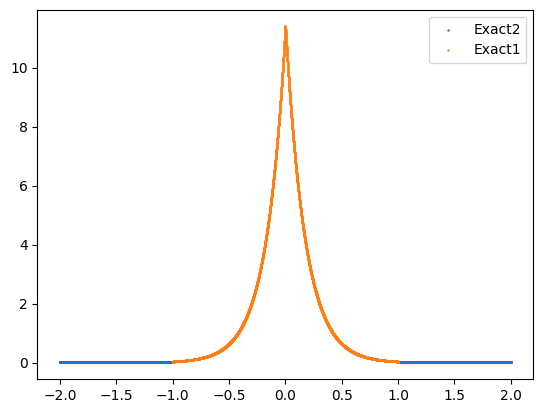

In [13]:
# testing
Ntest = 10000
x21 = np.linspace(-a, -a / 2, Ntest // 4).reshape((Ntest // 4, 1))
x22 = np.linspace(a / 2, a, Ntest // 4).reshape((Ntest // 4, 1))
x2 = np.concatenate((x21, x22), axis=0).reshape((Ntest // 2, 1))
fig = plt.figure()
ax = fig.gca()
Exact2 = ExactPhi2(x2, L1, D1, L2, D2, S, a)
plt.scatter(x2, Exact2, label="Exact2", marker=".", s=2)
x11 = np.linspace(-a / 2, 0, Ntest // 4).reshape((Ntest // 4, 1))
x12 = np.linspace(0, a / 2, Ntest // 4).reshape((Ntest // 4, 1))
x1 = np.concatenate((x11, x12), axis=0).reshape((Ntest // 2, 1))
Exact1 = ExactPhi1(x1, L1, D1, L2, D2, S, a)
plt.scatter(x1, Exact1, label="Exact1", marker=".", s=2)
plt.legend()
plt.savefig("%s/Exact.pdf" % new_folder_path)